# Recommender System using Text Based Similarity

In [1]:
# All necessary imports

import pandas as pd
import numpy as np
from collections import Counter
import itertools
import nltk
from nltk.corpus import stopwords
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
import pickle
import warnings
warnings.filterwarnings("ignore")

In [4]:
#reading the json data using pandas
data = pd.read_json('tops_fashion.json')

In [5]:
print('Number of data points: ',data.shape[0])
print('Number of features: ', data.shape[1])

Number of data points:  183138
Number of features:  19


In [6]:
data.head(3)

,sku,asin,product_type_name,formatted_price,author,color,brand,publisher,availability,reviews,large_image_url,availability_type,small_image_url,editorial_review,title,model,medium_image_url,manufacturer,editorial_reivew
0,None,B016I2TS4W,SHIRT,None,None,None,FNC7C,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Women's O Nec...,Minions Como Superheroes Ironman Long Sleeve R...,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
1,None,B01N49AI08,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Izo Tunic,None,https://images-na.ssl-images-amazon.com/images...,None,NaN
2,None,B01JDPCOHO,SHIRT,None,None,None,FIG Clothing,None,None,"[False, https://www.amazon.com/reviews/iframe?...",https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,Sizing runs on the small side. FIG® recommends...,FIG Clothing Womens Won Top,None,https://images-na.ssl-images-amazon.com/images...,None,NaN


In [7]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

The features used for this project are:

    1. asin: Amazon standard identification number
    2. brand: brand name of the apparal
    3. color : color information of apparal
    4. product_type_name : type of apparal to which the product belongs 
    5. medium_image_url : url of the image
    5. title : Title of the product
    7. formatted_price : price of the product

In [8]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
data.head(3)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None


In [9]:
print('Number of data points: ',data.shape[0])
print('Number of features: ', data.shape[1])

Number of data points:  183138
Number of features:  7


### Describing the data features and Dealing with Missing Data 

##### Brand Column 

In [10]:
data['brand'].describe()
print()
print('Number of missing values in brand column: ',data.shape[0]-182987)


Number of missing values in brand column:  151


In [11]:
brand = Counter(data['brand'].to_list())
brand.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

The distribution of brand names is quite uniform

##### Product type name column

In [12]:
data['product_type_name'].describe()
print()
print('Number of missing values in product name column: ',data.shape[0]-183138)


Number of missing values in product name column:  0


In [13]:
pdt = Counter(data['product_type_name'].to_list())
pdt.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [14]:
print(167794/data.shape[0]*100, '% of product type name is SHIRT')

91.62161867007393 % of product type name is SHIRT


##### Color column

In [15]:
print(data['color'].describe())
print()
print('Number of missing values in color column: ',data.shape[0]-64956)

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

Number of missing values in color column:  118182


In [16]:
color = Counter(data['color'].to_list())
color.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

##### Formatted price column

In [17]:
print(data['formatted_price'].describe())
print()
print('Number of missing values in formatted price column: ',data.shape[0]-28395)

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

Number of missing values in formatted price column:  154743


In [18]:
price = Counter(data['formatted_price'].to_list())
price.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

##### Title column

In [19]:
print(data['title'].describe())

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [20]:
print('Number of missing values in title column: ', data.shape[0]-183138)

Number of missing values in title column:  0


#### A lot of values are missing in the price column and color column. All the rows with None price value and color value are dropped.

In [21]:
#dropping null price data points
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points after dropping the NULL values: ', data.shape[0])

Number of data points after dropping the NULL values:  28395


In [22]:
data = data.loc[~data['color'].isnull()]
print('Number of data points after dropping the NULL values: ', data.shape[0])

Number of data points after dropping the NULL values:  28385


In [23]:
#Missing values after removal of data points
data.isnull().sum()

asin                  0
brand                93
color                 0
medium_image_url      0
product_type_name     0
title                 0
formatted_price       0
dtype: int64

### Dealing with Duplicates : De duplication

In [24]:
data.duplicated('title').sum()

2325

In [25]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>=4)]
data_sorted.shape[0]

28172

In [26]:
#sorting the data based on title
data_sorted.sort_values('title', inplace = True, ascending = False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


##### Removing very similar titles to improve the recommender system

In [27]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
print(indices[0:10])

[61973, 133820, 81461, 75995, 151570, 152506, 76209, 103647, 138588, 95954]


In [28]:
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])


            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [29]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [30]:
print('Number of data points : ', data.shape[0])

Number of data points :  17720


#### This is second stage of de duplication where every (i,j) pair of titles. This is a more time intensive method of removing titles that differ by less than 3 words.

In [31]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        
        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [32]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [33]:
print('Number of data points after stage two of dedupe: ',data.shape[0])

Number of data points after stage two of dedupe:  16548


In [34]:
data.to_pickle('deduped_data')

## Text Preprocessing

In [35]:
data = pd.read_pickle('deduped_data')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel O Nec...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Fifth Degree Womens Gold Foil Graphic Tees Jun...,$6.95


##### Removing stopwords and special characters from title feature

In [37]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cssch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [38]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print('List of all English stop words in NLTK:')
print(stop_words)

List of all English stop words in NLTK:
{'why', "hadn't", 'ourselves', 'to', 're', 'any', 'above', 'am', 'we', 'further', 'after', 'being', 'against', 'won', 'themselves', 'me', 'before', 'on', 'again', 'too', 'both', 'how', 'all', 'by', 'd', 'couldn', 'm', "couldn't", "don't", 'and', 'very', 'this', 'myself', 'having', 'of', 'aren', "you'll", 'yourself', 'o', 'hasn', "mustn't", 'through', 'below', 'only', "wouldn't", 'their', 'now', 'needn', 'our', 'himself', 'wasn', 'more', 'if', "shouldn't", "you'd", 'most', 'herself', 'off', 'll', 'didn', "mightn't", 'shouldn', 'which', 'my', 'your', 'same', 'hers', 'between', 'had', 'in', 'y', 'not', 'wouldn', 'no', 'they', 'while', 'don', 'as', 'other', 'itself', 'her', 'has', 'until', 'then', 'own', 'doing', 'some', 'whom', 'can', 'does', 'a', 'what', 'ma', "you've", 'the', 'you', 'that', 'was', 'at', 'during', 'it', "that'll", 'been', 'with', "wasn't", 'an', 've', 'for', 'just', 'his', 't', "should've", "it's", "aren't", 'haven', "haven't", 'be

In [39]:
def remove_stop_words(text):
    
    string = ''
    word_list = text.split()
    for word in word_list:
        if not word.lower().isalnum() or word.lower() in stop_words:
            word_list.remove(word)
    for ele in word_list:
        string = string+ ' ' +ele.lower()
        
    return string

In [40]:
data['title'] = data['title'].map(lambda x: remove_stop_words(x))
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite long sleeve stain resistant taper...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,unique cotton - special olympics world games ...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite moisture free mesh sport white xx...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck for...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees ju...,$6.95


## Text Based Product Recommendation

### Using Bag of Words Model

In [41]:
### function to display image
def display_img(url):
    gs = gridspec.GridSpec(2, 2) 
    fig = plt.figure(figsize=(20,6))
    ax = plt.subplot(gs[0])

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    plt.imshow(img)
    plt.show()

In [42]:
# BOW model
title_vectorizer = CountVectorizer()
title_features = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16548, 10393)

In [43]:
# function to use calculate euclidean distance based on BOW model 
def bag_of_words_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        
        display_img(data['medium_image_url'].loc[df_indices[i]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)


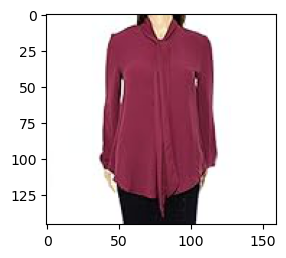

ASIN : B0754NKWZ8
Brand: Harlowe & Graham
Title:  harlowe graham womens textured blouse purple xs
Euclidean similarity with the query image : 0.0


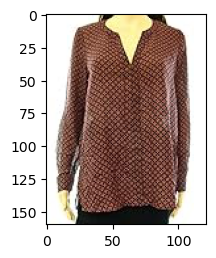

ASIN : B01GRY91OS
Brand: Harlowe & Graham
Title:  harlowe graham women's small blouse purple
Euclidean similarity with the query image : 2.23606797749979


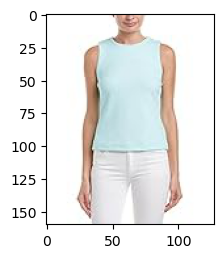

ASIN : B06Y56VRSV
Brand: J. McLaughlin
Title:  womens xs
Euclidean similarity with the query image : 2.23606797749979


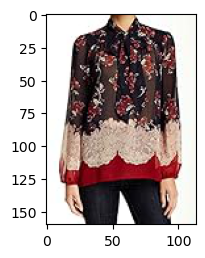

ASIN : B074NB6FTW
Brand: Harlowe & Graham
Title:  harlowe graham womens floral print blouse blue xs
Euclidean similarity with the query image : 2.23606797749979


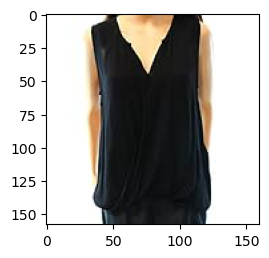

ASIN : B0756H1M98
Brand: Harlowe & Graham
Title:  harlowe graham womens small blouse black
Euclidean similarity with the query image : 2.23606797749979


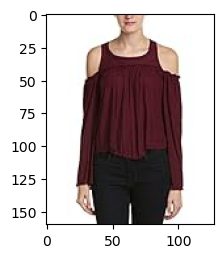

ASIN : B01N0YGSX2
Brand: CHASER
Title:  chaser womens blouse, purple
Euclidean similarity with the query image : 2.23606797749979


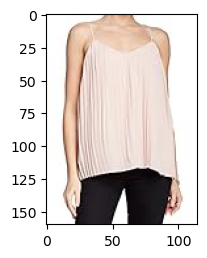

ASIN : B074P8YBRL
Brand: Harlowe & Graham
Title:  harlowe graham light womens pleated blouse pink xs
Euclidean similarity with the query image : 2.23606797749979


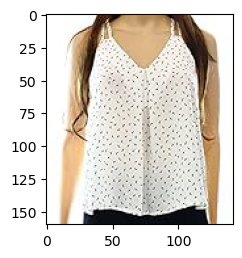

ASIN : B0728D8YK2
Brand: Harlowe & Graham
Title:  harlowe graham black strappy blouse white xs
Euclidean similarity with the query image : 2.449489742783178


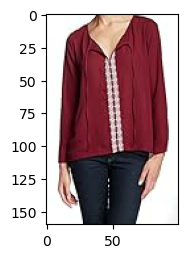

ASIN : B06XD3SNM8
Brand: Harlowe & Graham
Title:  harlowe graham burgundy embroidered blouse red xs
Euclidean similarity with the query image : 2.449489742783178


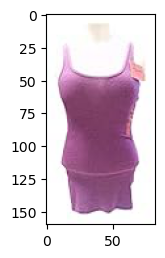

ASIN : B071RYBNJ3
Brand: Mossimo
Title:  mossimo womens tank purple xs
Euclidean similarity with the query image : 2.449489742783178


In [44]:
bag_of_words_model(12566, 10) # doc_id = 12566

### The first image is the query image. Following are product recommendations based on the query image. 

### Using TF-IDF model

In [46]:
tfidf_title_vectorizer = TfidfVectorizer(min_df=0.01)  # or min_df=1
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

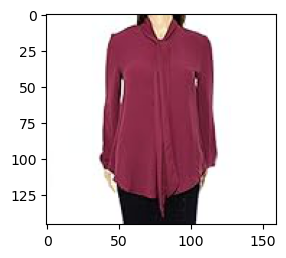

ASIN : B0754NKWZ8
BRAND : Harlowe & Graham
Eucliden distance from the given image : 0.0


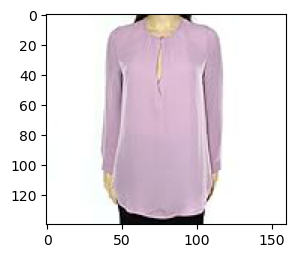

ASIN : B0753KM6S7
BRAND : Collective Concepts
Eucliden distance from the given image : 0.0


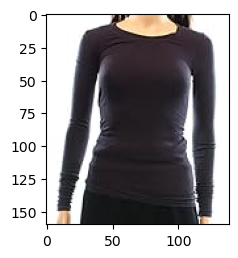

ASIN : B071VW5C75
BRAND : H By Bordeaux
Eucliden distance from the given image : 0.3827090629126554


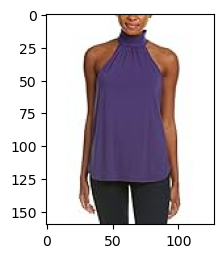

ASIN : B0753MK8MQ
BRAND : susana monaco
Eucliden distance from the given image : 0.3831070647419375


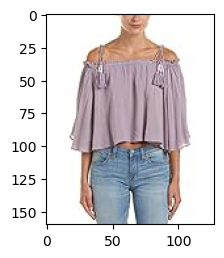

ASIN : B073HFJ8TK
BRAND : Young Fabulous & Broke
Eucliden distance from the given image : 0.3831070647419375


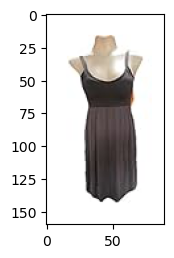

ASIN : B071KRVDGM
BRAND : Gilligan & O'Malley
Eucliden distance from the given image : 0.4867659372059963


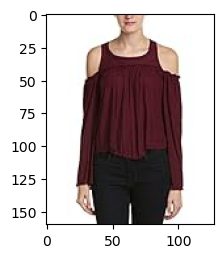

ASIN : B01N0YGSX2
BRAND : CHASER
Eucliden distance from the given image : 0.5533531992014282


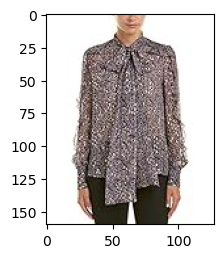

ASIN : B074QW4RVR
BRAND : Jill Stuart
Eucliden distance from the given image : 0.5533531992014282


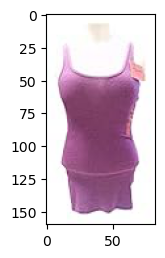

ASIN : B071RYBNJ3
BRAND : Mossimo
Eucliden distance from the given image : 0.557863041784786


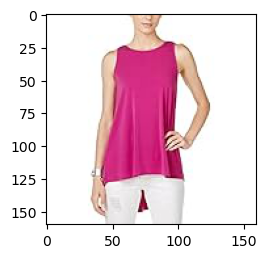

ASIN : B071KZ2PGN
BRAND : Vince Camuto
Eucliden distance from the given image : 0.5815713224619696


In [47]:
def tfidf_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        
        display_img( data['medium_image_url'].loc[df_indices[i]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*60)
tfidf_model(12566, 10)

### The first image is the query image, rest are recommendations.

## Conclusion:
#### The TF-IDF based model produced better recommendations than BOW based model. 
#### This could be due to the fact the tfidf is a better method of vectorizing text which in turn produces more meaningful distance metrics from the query image title vector.


TF-IDF helps identify words that are unique or significant to individual documents. In recommendation systems, TF-IDF can be used to measure text similarity, allowing it to find items with similar descriptions or content.

# THE END